In [179]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

In [167]:
class RandomForest():
    def __init__(self):
        from sklearn.tree import DecisionTreeClassifier
        self.trees = []
        self.features_idx = []
        
    def fit(self, X, y, ntree=10, max_depth=None):
        n_samples = X.shape[0]
        m_features = X.shape[1]
        sampsize = int(np.round(0.632 * n_samples))
        mtry = int(np.round(np.sqrt(m_features)))
        for _ in range(ntree):
            row_idx = np.random.randint(0, n_samples, sampsize)
            col_idx = np.random.randint(0, m_features, mtry)
            tree = DecisionTreeClassifier(criterion='gini', max_depth=max_depth)
            tree.fit(X[row_idx[:, None], col_idx], y[row_idx])
            self.trees.append(tree)
            self.features_idx.append(col_idx)
    
    def predict(self, X, n_classes=2, voting='soft'):
        ntree = len(self.trees)
        n_samples = X.shape[0]
        predictions = np.zeros([ntree, n_samples, n_classes]) # 3d-array of shape <ntree, test_size, n_classes>
        for i in range(0, ntree):
            if voting == 'soft':
                predictions[i, :, :] = self.trees[i].predict_proba(X[:, self.features_idx[i]])
            if voting == 'hard':
                P = np.zeros([n_samples, n_classes])
                P[np.arange(n_samples), self.trees[i].predict(X[:, self.features_idx[i]])] = 1
                predictions[i, :, :] = P
        mean_predictions = np.mean(predictions, axis=0)
        classes = np.argmax(mean_predictions, axis=1)
        return mean_predictions, classes

In [172]:
def ROC_AUC(y, probabilities):
    shifts = sorted(list(zip(probabilities, y)), reverse=True)
    step_x = 1/np.where(y != 1)[0].shape[0]
    step_y = 1/np.where(y == 1)[0].shape[0]
    points_x = [0]
    points_y = [0]
    last_x = 0
    last_y = 0
    auc = 0
    for prob, sample_y in shifts:
        if sample_y == 1:
            points_x.append(last_x)
            last_y += step_y
            points_y.append(last_y)
        else:
            points_y.append(last_y)
            last_x += step_x
            points_x.append(last_x)
            auc += step_x * last_y
    return auc, points_x, points_y

### Spam dataset

In [215]:
spam_df = pd.read_csv('../data/spam.csv')
X = spam_df[spam_df.columns.difference(['label'])].values
y = spam_df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

20 trees, max_depth = 3

Text(0.5, 1.0, '[SPAM], ntree: 20, max_depth:3, AUC: 0.9575933169153539, accuracy: 0.8490770901194354')

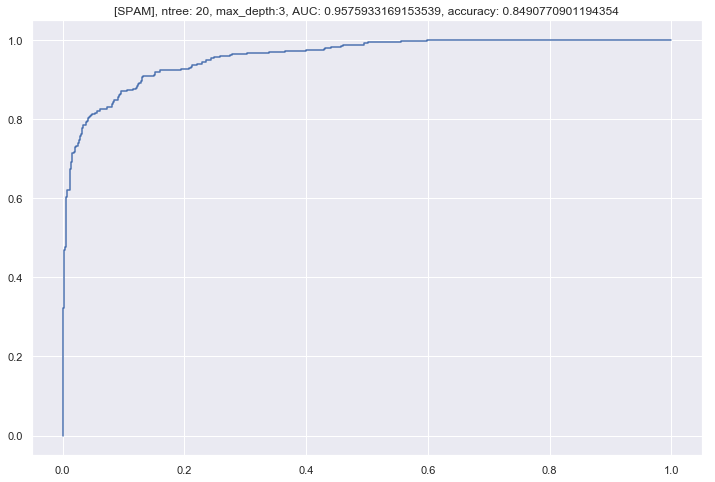

In [219]:
ntree = 20
max_depth = 3
rf = RandomForest()
rf.fit(X_train, y_train, ntree=ntree, max_depth=max_depth)
probs, classes = rf.predict(X_test)

auc, points_x, points_y = ROC_AUC(y_test, probs[:, 1]) # probabilities of the 2nd class
accuracy = accuracy_score(y_test, classes)

plt.figure(figsize=(12, 8))
plt.plot(points_x, points_y)
plt.title(f"[SPAM], ntree: {ntree}, max_depth:{max_depth}, AUC: {auc}, accuracy: {accuracy}")

Cross validation

In [221]:
ntree_p = [5, 10, 20, 30, 50, 100]
max_depth_p = [2, 3, 5, 7, 10]

best_auc = None
best_ntree = None
best_max_depth = None

kf = KFold(n_splits=5, random_state=42, shuffle=False)
for ntree in ntree_p:
    for max_depth in max_depth_p:
        roc_auc_CV = []
        for train_index, val_index in kf.split(X_train):
            X_train_new, X_val = X_train[train_index], X_train[val_index]
            y_train_new, y_val = y_train[train_index], y_train[val_index]
            rf = RandomForest()
            rf.fit(X_train_new, y_train_new, ntree=ntree, max_depth=max_depth)
            probs, classes = rf.predict(X_val)
            auc, points_x, points_y = ROC_AUC(y_val, probs[:, 1])
            roc_auc_CV.append(auc)
        auc = np.mean(roc_auc_CV)
        print(f"ntree: {ntree}, max_depth: {max_depth}, auc: {auc}")
        if not best_auc or best_auc < auc:
            best_auc = auc
            best_ntree = ntree
            best_max_depth = max_depth
print('--')            
print(f"best ntree: {best_ntree}, best max_depth: {best_max_depth}, AUC: {best_auc}")

ntree: 5, max_depth: 2, auc: 0.9370234751723663
ntree: 5, max_depth: 3, auc: 0.9416022438224584
ntree: 5, max_depth: 5, auc: 0.9415684412122328
ntree: 5, max_depth: 7, auc: 0.9378344800790808
ntree: 5, max_depth: 10, auc: 0.9436877418483837
ntree: 10, max_depth: 2, auc: 0.9480144084484406
ntree: 10, max_depth: 3, auc: 0.9532841579052495
ntree: 10, max_depth: 5, auc: 0.9643396555785229
ntree: 10, max_depth: 7, auc: 0.9567627152211525
ntree: 10, max_depth: 10, auc: 0.9618899119023808
ntree: 20, max_depth: 2, auc: 0.9509200814212369
ntree: 20, max_depth: 3, auc: 0.9565925760757172
ntree: 20, max_depth: 5, auc: 0.9654871430623377
ntree: 20, max_depth: 7, auc: 0.9679355564447951
ntree: 20, max_depth: 10, auc: 0.9676811816210453
ntree: 30, max_depth: 2, auc: 0.9571275946853481
ntree: 30, max_depth: 3, auc: 0.9589432559240224
ntree: 30, max_depth: 5, auc: 0.9686209182222566
ntree: 30, max_depth: 7, auc: 0.9719464885659269
ntree: 30, max_depth: 10, auc: 0.9723969989540032
ntree: 50, max_depth:

ROC-curve on the test set (optimal parameters)

Text(0.5, 1.0, '[SPAM], ntree: 100, max_depth: 10, AUC: 0.9784972717176142, accuracy: 0.9022801302931596')

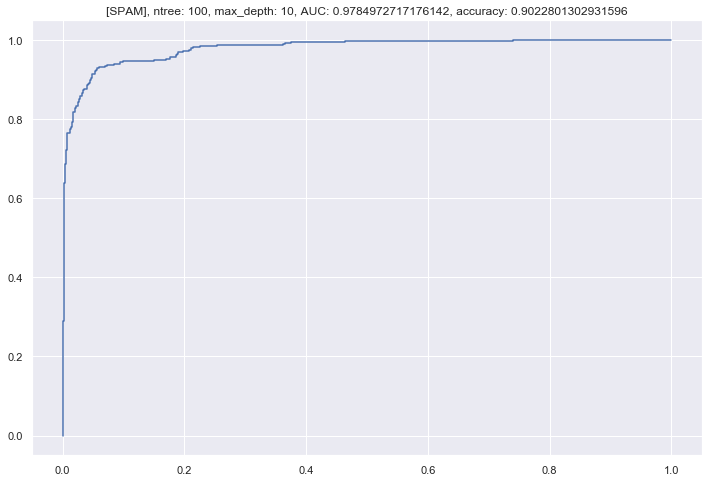

In [222]:
ntree = best_ntree
max_depth = best_max_depth
rf = RandomForest()
rf.fit(X_train, y_train, ntree=ntree, max_depth=max_depth)
probs, classes = rf.predict(X_test)

auc, points_x, points_y = ROC_AUC(y_test, probs[:, 1]) # probabilities of the 2nd class
accuracy = accuracy_score(y_test, classes)

plt.figure(figsize=(12, 8))
plt.plot(points_x, points_y)
plt.title(f"[SPAM], ntree: {ntree}, max_depth: {max_depth}, AUC: {auc}, accuracy: {accuracy}")

### Cancer dataset

In [223]:
cancer_df = pd.read_csv('../data/cancer.csv')
cancer_df['int_label'] = cancer_df.label.map({'M':1, 'B':0})
cancer_df['label'] = cancer_df.int_label
cancer_df.drop('int_label', axis=1, inplace=True)
X = cancer_df[cancer_df.columns.difference(['label'])].values
y = cancer_df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

20 trees, max_depth = 3

Text(0.5, 1.0, '[Cancer], ntree: 20, max_depth:3, AUC: 0.995741893219783, accuracy: 0.956140350877193')

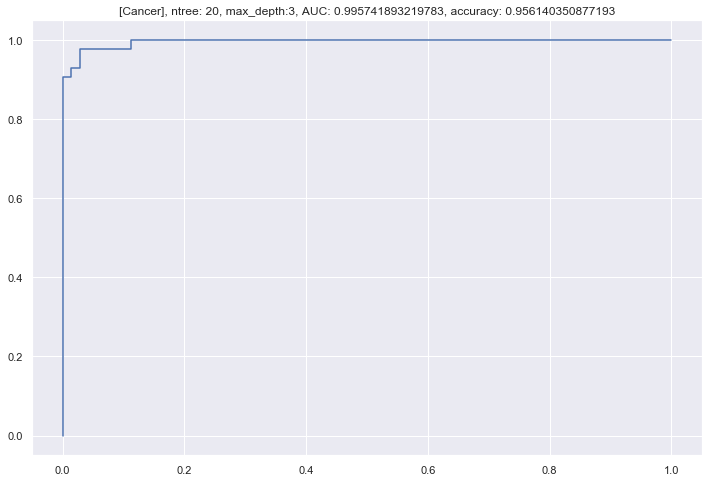

In [224]:
ntree = 20
max_depth = 3
rf = RandomForest()
rf.fit(X_train, y_train, ntree=ntree, max_depth=max_depth)
probs, classes = rf.predict(X_test)

auc, points_x, points_y = ROC_AUC(y_test, probs[:, 1]) # probabilities of the 2nd class
accuracy = accuracy_score(y_test, classes)

plt.figure(figsize=(12, 8))
plt.plot(points_x, points_y)
plt.title(f"[Cancer], ntree: {ntree}, max_depth:{max_depth}, AUC: {auc}, accuracy: {accuracy}")

Cross validation

In [225]:
ntree_p = [5, 10, 20, 30, 50, 100]
max_depth_p = [2, 3, 5, 7, 10]

best_auc = None
best_ntree = None
best_max_depth = None

kf = KFold(n_splits=5, random_state=42, shuffle=False)
for ntree in ntree_p:
    for max_depth in max_depth_p:
        roc_auc_CV = []
        for train_index, val_index in kf.split(X_train):
            X_train_new, X_val = X_train[train_index], X_train[val_index]
            y_train_new, y_val = y_train[train_index], y_train[val_index]
            rf = RandomForest()
            rf.fit(X_train_new, y_train_new, ntree=ntree, max_depth=max_depth)
            probs, classes = rf.predict(X_val)
            auc, points_x, points_y = ROC_AUC(y_val, probs[:, 1])
            roc_auc_CV.append(auc)
        auc = np.mean(roc_auc_CV)
        print(f"ntree: {ntree}, max_depth: {max_depth}, auc: {auc}")
        if not best_auc or best_auc < auc:
            best_auc = auc
            best_ntree = ntree
            best_max_depth = max_depth
print('--')            
print(f"best ntree: {best_ntree}, best max_depth: {best_max_depth}, AUC: {best_auc}")

ntree: 5, max_depth: 2, auc: 0.9807783073438754
ntree: 5, max_depth: 3, auc: 0.983581346095392
ntree: 5, max_depth: 5, auc: 0.9777235799480583
ntree: 5, max_depth: 7, auc: 0.9805006446403063
ntree: 5, max_depth: 10, auc: 0.9734380824097142
ntree: 10, max_depth: 2, auc: 0.9784900689001936
ntree: 10, max_depth: 3, auc: 0.9814809305680434
ntree: 10, max_depth: 5, auc: 0.9831916984159115
ntree: 10, max_depth: 7, auc: 0.9885337205220456
ntree: 10, max_depth: 10, auc: 0.9892785137616187
ntree: 20, max_depth: 2, auc: 0.9828179593608006
ntree: 20, max_depth: 3, auc: 0.9865215714490644
ntree: 20, max_depth: 5, auc: 0.9849567634776619
ntree: 20, max_depth: 7, auc: 0.987322205270314
ntree: 20, max_depth: 10, auc: 0.9874249278753151
ntree: 30, max_depth: 2, auc: 0.9849213432616949
ntree: 30, max_depth: 3, auc: 0.9852580910985868
ntree: 30, max_depth: 5, auc: 0.9882410416539005
ntree: 30, max_depth: 7, auc: 0.9900479379592451
ntree: 30, max_depth: 10, auc: 0.9892789565788263
ntree: 50, max_depth: 2

ROC-curve on the test set (optimal parameters)

Text(0.5, 1.0, '[Cancer], ntree: 30, max_depth: 7, AUC: 0.9954143465443818, accuracy: 0.9649122807017544')

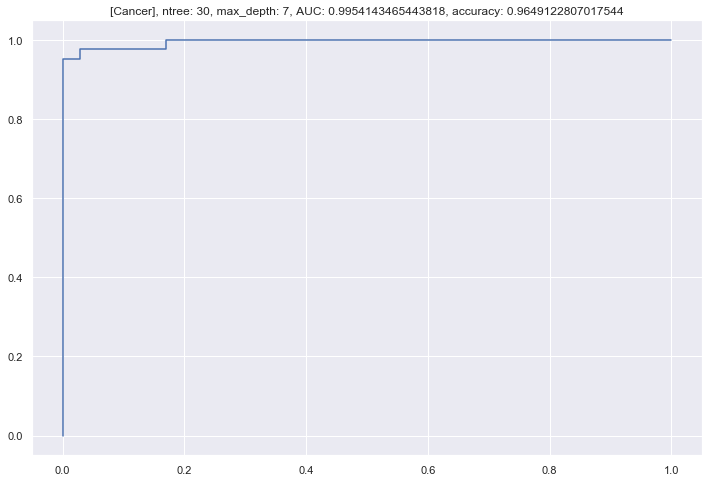

In [227]:
ntree = best_ntree
max_depth = best_max_depth
rf = RandomForest()
rf.fit(X_train, y_train, ntree=ntree, max_depth=max_depth)
probs, classes = rf.predict(X_test)

auc, points_x, points_y = ROC_AUC(y_test, probs[:, 1]) # probabilities of the 2nd class
accuracy = accuracy_score(y_test, classes)

plt.figure(figsize=(12, 8))
plt.plot(points_x, points_y)
plt.title(f"[Cancer], ntree: {ntree}, max_depth: {max_depth}, AUC: {auc}, accuracy: {accuracy}")